In [11]:
import torch
from torch import nn
import torchvision

import Utils

In [12]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
X_DIM = 28
LATENT_DIM = 100
HIDDEN = 84
EPOCH_NUM = 300
lr = 0.0001

In [13]:
device = Utils.get_device()
dataloader = Utils.get_loader(torchvision.datasets.FashionMNIST, X_DIM, BATCH_SIZE, normalize=False)

Using device: cuda
Data loaded


## Sample images from the dataset

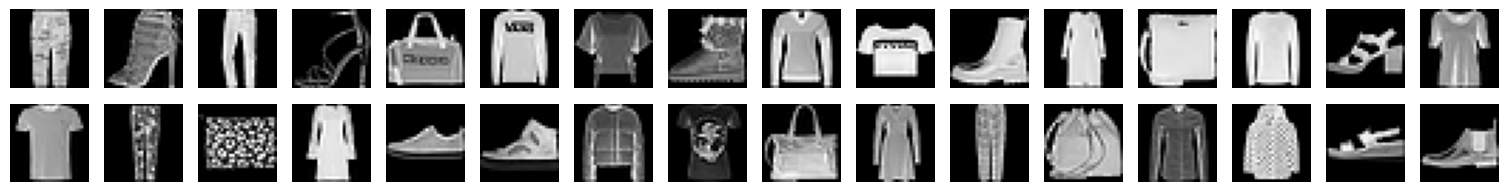

In [14]:
Utils.plot_real(dataloader, X_DIM)

## Model Architecture and Configuration

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, HIDDEN, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN, 14, 14)
            # 2nd layer
            nn.Conv2d(HIDDEN, HIDDEN * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN * 2),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN * 2, 7, 7)
            # 3rd layer
            nn.Conv2d(HIDDEN * 2, HIDDEN * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN * 4),
            nn.LeakyReLU(0.1, inplace=True),  # shape: (HIDDEN * 4, 7, 7)
            nn.Flatten()  # shape: (HIDDEN * 4 * 7 * 7,)
        )
        output_dim = HIDDEN * 4 * 7 * 7
        self.mean = nn.Linear(output_dim, LATENT_DIM)
        self.log_var = nn.Linear(output_dim, LATENT_DIM)
        
    def forward(self, x):
        x = self.main(x)
        z_mean = self.mean(x)
        z_log_var = self.log_var(x)
        std = torch.exp(0.5 * z_log_var)
        epsilon = torch.randn(x.size(0), LATENT_DIM).to(device)
        z = z_mean + std * epsilon
        return z, z_mean, z_log_var

In [16]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Linear(LATENT_DIM, HIDDEN * 4 * 7 * 7),
            Reshape(HIDDEN * 4, 7, 7),
            nn.BatchNorm2d(HIDDEN * 4),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN * 4, 7, 7)
            # 2nd layer
            nn.ConvTranspose2d(HIDDEN * 4, HIDDEN * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN * 2),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN * 2, 7, 7) 
            # 3rd layer
            nn.ConvTranspose2d(HIDDEN * 2, HIDDEN, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(HIDDEN),
            nn.LeakyReLU(0.1),  # shape: (HIDDEN, 14, 14)
            # 4th layer
            nn.ConvTranspose2d(HIDDEN, IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # shape: (IMAGE_CHANNEL, 28, 28)
        )
        
    def forward(self, x):
        return self.main(x)
    
    def generate(self, cnt):
        z = torch.randn(cnt, LATENT_DIM).to(device)
        return self.main(z)

In [18]:
netE = Encoder().to(device)
print('Number of parameters in the encoder:', Utils.get_n_params(netE))

netD = Decoder().to(device)
print('Number of parameters in the decoder:', Utils.get_n_params(netD))

criterion = Utils.vae_loss
viz_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)

optimizer = torch.optim.Adam(list(netE.parameters()) + list(netD.parameters()), lr=lr, betas=(0.5, 0.999))

Number of parameters in the encoder: 4029932
Number of parameters in the decoder: 2399461


## Training loop

[1/300][468/469]	Loss: 26990.8672
[2/300][468/469]	Loss: 26045.7617
[3/300][468/469]	Loss: 25389.6621
[4/300][468/469]	Loss: 25190.7344
[5/300][468/469]	Loss: 24904.7891
[6/300][468/469]	Loss: 23992.1641
[7/300][468/469]	Loss: 23550.2090
[8/300][468/469]	Loss: 23275.5664
[9/300][468/469]	Loss: 23020.0000
[10/300][468/469]	Loss: 24828.8711
[11/300][468/469]	Loss: 23274.5391
[12/300][468/469]	Loss: 23296.9121
[13/300][468/469]	Loss: 24134.5234
[14/300][468/469]	Loss: 22663.5449
[15/300][468/469]	Loss: 23126.4824
[16/300][468/469]	Loss: 24219.5273
[17/300][468/469]	Loss: 22895.2324
[18/300][468/469]	Loss: 23606.3984
[19/300][468/469]	Loss: 23258.1797
[20/300][468/469]	Loss: 24183.0586
[21/300][468/469]	Loss: 23731.5156
[22/300][468/469]	Loss: 23888.9199
[23/300][468/469]	Loss: 23020.1445
[24/300][468/469]	Loss: 22120.6250
[25/300][468/469]	Loss: 22398.4473


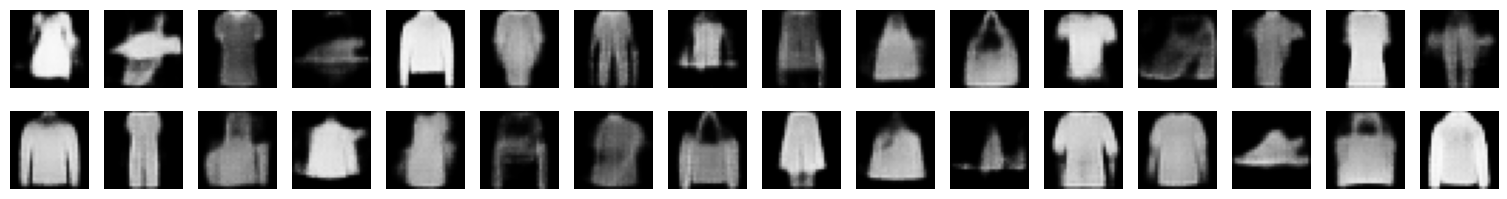

[26/300][468/469]	Loss: 22418.7617
[27/300][468/469]	Loss: 23216.2773
[28/300][468/469]	Loss: 22187.0156
[29/300][468/469]	Loss: 22969.3516
[30/300][468/469]	Loss: 23223.6582
[31/300][468/469]	Loss: 23278.1348
[32/300][468/469]	Loss: 23539.1035
[33/300][468/469]	Loss: 22249.1289
[34/300][468/469]	Loss: 23892.2852
[35/300][468/469]	Loss: 21623.3125
[36/300][468/469]	Loss: 23806.5195
[37/300][468/469]	Loss: 23372.1582
[38/300][468/469]	Loss: 23036.5605
[39/300][468/469]	Loss: 22848.7012
[40/300][468/469]	Loss: 22209.4082
[41/300][468/469]	Loss: 24502.8027
[42/300][468/469]	Loss: 22811.0137
[43/300][468/469]	Loss: 23482.5371
[44/300][468/469]	Loss: 23265.2559
[45/300][468/469]	Loss: 23002.2793
[46/300][468/469]	Loss: 22868.4668
[47/300][468/469]	Loss: 23842.2754
[48/300][468/469]	Loss: 23960.6406
[49/300][468/469]	Loss: 24614.7441
[50/300][468/469]	Loss: 21710.0801


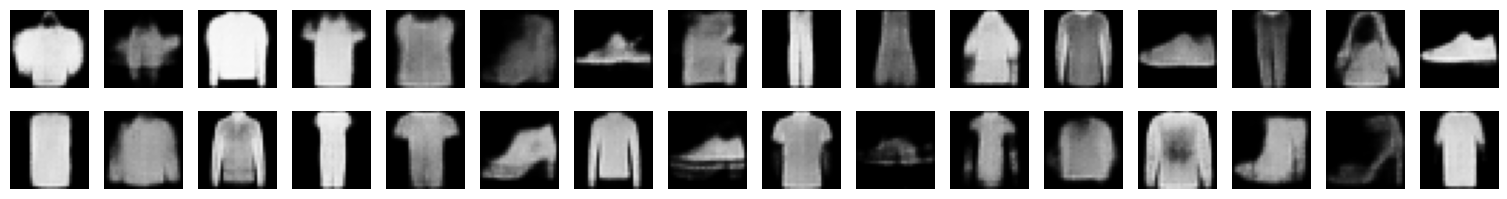

[51/300][468/469]	Loss: 22588.8906
[52/300][468/469]	Loss: 23786.3477
[53/300][468/469]	Loss: 22640.6211
[54/300][468/469]	Loss: 21725.9355
[55/300][468/469]	Loss: 23372.4492
[56/300][468/469]	Loss: 22201.8320
[57/300][468/469]	Loss: 22918.5898
[58/300][468/469]	Loss: 23340.9102
[59/300][468/469]	Loss: 22034.7812
[60/300][468/469]	Loss: 23685.8535
[61/300][468/469]	Loss: 21646.9277
[62/300][468/469]	Loss: 23267.2598
[63/300][468/469]	Loss: 22778.4121
[64/300][468/469]	Loss: 21706.4531
[65/300][468/469]	Loss: 21954.1641
[66/300][468/469]	Loss: 23763.5039
[67/300][468/469]	Loss: 23092.7383
[68/300][468/469]	Loss: 22371.6387
[69/300][468/469]	Loss: 21790.9199
[70/300][468/469]	Loss: 23404.2324
[71/300][468/469]	Loss: 23968.0488
[72/300][468/469]	Loss: 24668.0957
[73/300][468/469]	Loss: 21684.0293
[74/300][468/469]	Loss: 23038.0312
[75/300][468/469]	Loss: 23837.0820


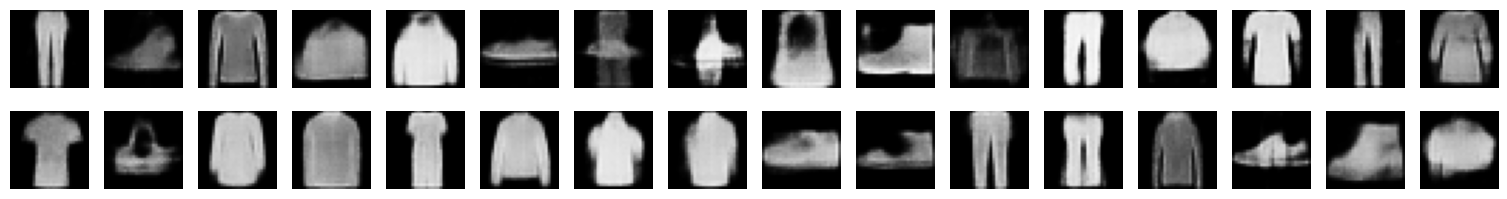

[76/300][468/469]	Loss: 23254.8438
[77/300][468/469]	Loss: 22907.0176
[78/300][468/469]	Loss: 22272.7969
[79/300][468/469]	Loss: 22883.3848
[80/300][468/469]	Loss: 21271.2656
[81/300][468/469]	Loss: 23101.9824
[82/300][468/469]	Loss: 22142.5430
[83/300][468/469]	Loss: 22664.2129
[84/300][468/469]	Loss: 21199.7129
[85/300][468/469]	Loss: 22714.6523
[86/300][468/469]	Loss: 22168.9004
[87/300][468/469]	Loss: 21829.9863
[88/300][468/469]	Loss: 21836.4570
[89/300][468/469]	Loss: 22212.7480
[90/300][468/469]	Loss: 21273.6367
[91/300][468/469]	Loss: 22713.0703
[92/300][468/469]	Loss: 22695.9922
[93/300][468/469]	Loss: 21641.4082
[94/300][468/469]	Loss: 22996.8555
[95/300][468/469]	Loss: 21778.1016
[96/300][468/469]	Loss: 22446.4844
[97/300][468/469]	Loss: 23140.8223
[98/300][468/469]	Loss: 24577.9473
[99/300][468/469]	Loss: 21610.7012
[100/300][468/469]	Loss: 23246.9297


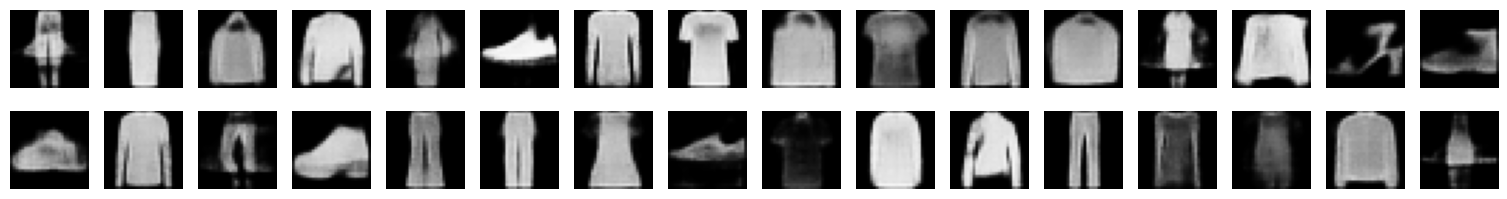

[101/300][468/469]	Loss: 23191.1172
[102/300][468/469]	Loss: 23919.9551
[103/300][468/469]	Loss: 22119.0469
[104/300][468/469]	Loss: 23594.7949
[105/300][468/469]	Loss: 21955.1582
[106/300][468/469]	Loss: 22325.3281
[107/300][468/469]	Loss: 22110.0625
[108/300][468/469]	Loss: 21804.5859
[109/300][468/469]	Loss: 21963.1211
[110/300][468/469]	Loss: 23028.7871
[111/300][468/469]	Loss: 23058.9414
[112/300][468/469]	Loss: 22387.3340
[113/300][468/469]	Loss: 22664.8906
[114/300][468/469]	Loss: 22706.2734
[115/300][468/469]	Loss: 22432.7012
[116/300][468/469]	Loss: 22175.6836
[117/300][468/469]	Loss: 23094.3438
[118/300][468/469]	Loss: 23261.2988
[119/300][468/469]	Loss: 22673.7246
[120/300][468/469]	Loss: 23099.5977
[121/300][468/469]	Loss: 22449.0566
[122/300][468/469]	Loss: 22920.4121
[123/300][468/469]	Loss: 22865.2891
[124/300][468/469]	Loss: 21971.5195
[125/300][468/469]	Loss: 23799.7402


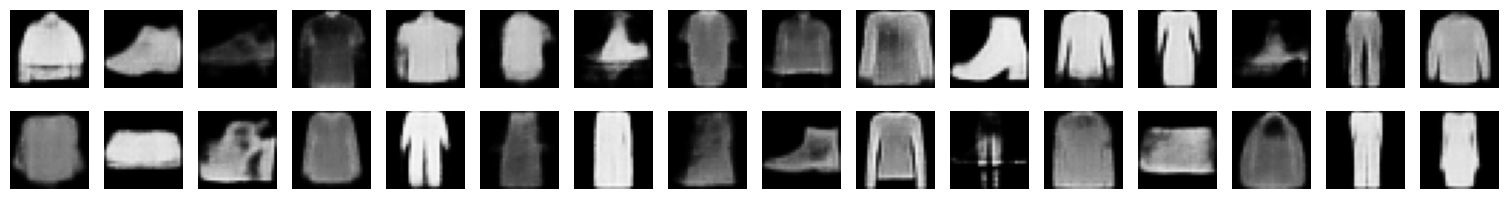

[126/300][468/469]	Loss: 20812.9238
[127/300][468/469]	Loss: 21175.9297
[128/300][468/469]	Loss: 22465.1523
[129/300][468/469]	Loss: 23509.1562
[130/300][468/469]	Loss: 21652.3223
[131/300][468/469]	Loss: 21681.5703
[132/300][468/469]	Loss: 22498.9531
[133/300][468/469]	Loss: 22974.0977
[134/300][468/469]	Loss: 22768.7070
[135/300][468/469]	Loss: 21518.1523
[136/300][468/469]	Loss: 22908.0352
[137/300][468/469]	Loss: 21597.2930
[138/300][468/469]	Loss: 22697.4883
[139/300][468/469]	Loss: 23513.7812
[140/300][468/469]	Loss: 22937.1270
[141/300][468/469]	Loss: 21987.5254
[142/300][468/469]	Loss: 22917.0645
[143/300][468/469]	Loss: 22672.4082
[144/300][468/469]	Loss: 22227.6074
[145/300][468/469]	Loss: 21742.8945
[146/300][468/469]	Loss: 21844.6621
[147/300][468/469]	Loss: 22427.1680
[148/300][468/469]	Loss: 23337.1621
[149/300][468/469]	Loss: 22409.6953
[150/300][468/469]	Loss: 22158.1641


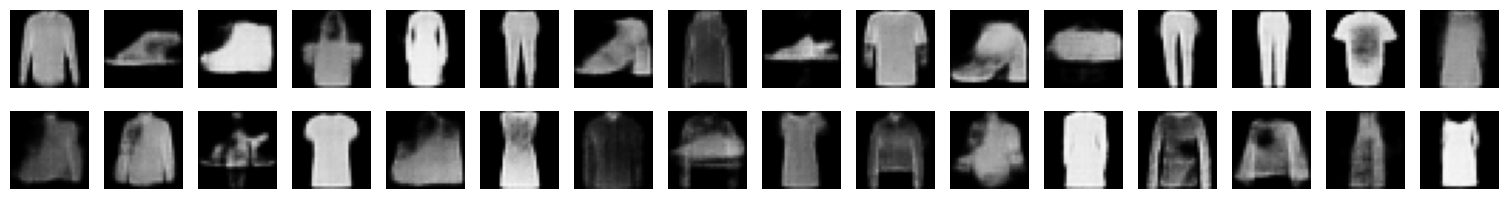

[151/300][468/469]	Loss: 22861.9180
[152/300][468/469]	Loss: 21535.4922
[153/300][468/469]	Loss: 24043.0449
[154/300][468/469]	Loss: 22269.3555
[155/300][468/469]	Loss: 21807.1523
[156/300][468/469]	Loss: 23263.2031
[157/300][468/469]	Loss: 23491.5488
[158/300][468/469]	Loss: 21207.5918
[159/300][468/469]	Loss: 22463.2695
[160/300][468/469]	Loss: 21503.3125
[161/300][468/469]	Loss: 21430.3828
[162/300][468/469]	Loss: 23032.1797
[163/300][468/469]	Loss: 22891.8008
[164/300][468/469]	Loss: 21506.6328
[165/300][468/469]	Loss: 22638.0938
[166/300][468/469]	Loss: 22864.1523
[167/300][468/469]	Loss: 22934.0332
[168/300][468/469]	Loss: 22622.6875
[169/300][468/469]	Loss: 22813.6074
[170/300][468/469]	Loss: 22040.9766
[171/300][468/469]	Loss: 21671.5625
[172/300][468/469]	Loss: 23626.0176
[173/300][468/469]	Loss: 23275.2441
[174/300][468/469]	Loss: 22235.1035
[175/300][468/469]	Loss: 22380.4980


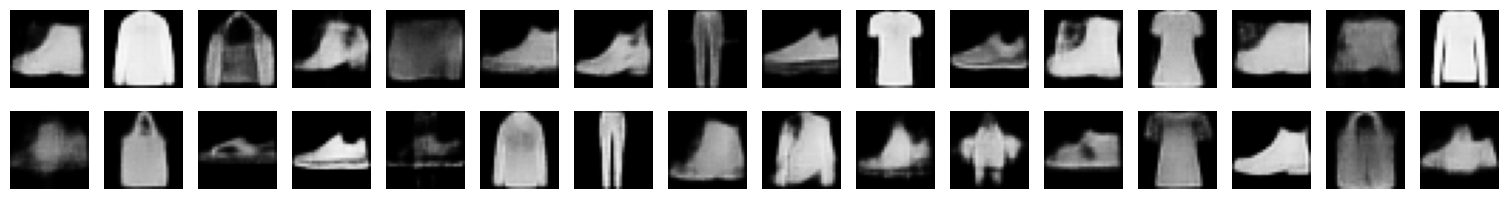

[176/300][468/469]	Loss: 22113.5215
[177/300][468/469]	Loss: 22506.7754
[178/300][468/469]	Loss: 22053.5078
[179/300][468/469]	Loss: 22340.4180
[180/300][468/469]	Loss: 23444.9648
[181/300][468/469]	Loss: 21341.2656
[182/300][468/469]	Loss: 21705.5215
[183/300][468/469]	Loss: 21629.1094
[184/300][468/469]	Loss: 22046.7383
[185/300][468/469]	Loss: 22738.5078
[186/300][468/469]	Loss: 21932.7500
[187/300][468/469]	Loss: 23140.3613
[188/300][468/469]	Loss: 22133.0918
[189/300][468/469]	Loss: 22846.8164
[190/300][468/469]	Loss: 22213.3574
[191/300][468/469]	Loss: 22959.2500
[192/300][468/469]	Loss: 21707.3086
[193/300][468/469]	Loss: 22287.0566
[194/300][468/469]	Loss: 22482.1250
[195/300][468/469]	Loss: 22457.1895
[196/300][468/469]	Loss: 23730.7090
[197/300][468/469]	Loss: 22388.1074
[198/300][468/469]	Loss: 21458.5977
[199/300][468/469]	Loss: 21464.8027
[200/300][468/469]	Loss: 22493.1484


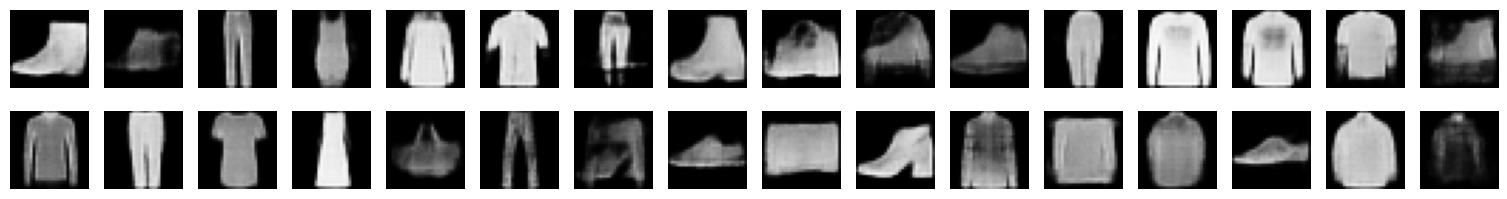

[201/300][468/469]	Loss: 22335.5039
[202/300][468/469]	Loss: 22355.1758
[203/300][468/469]	Loss: 23229.1621
[204/300][468/469]	Loss: 22767.1855
[205/300][468/469]	Loss: 22309.3066
[206/300][468/469]	Loss: 23770.2227
[207/300][468/469]	Loss: 21893.8027
[208/300][468/469]	Loss: 23320.6250
[209/300][468/469]	Loss: 22654.5234
[210/300][468/469]	Loss: 22212.7734
[211/300][468/469]	Loss: 23246.0996
[212/300][468/469]	Loss: 22634.7031
[213/300][468/469]	Loss: 22585.1836
[214/300][468/469]	Loss: 22600.5898
[215/300][468/469]	Loss: 23984.7168
[216/300][468/469]	Loss: 23989.7227
[217/300][468/469]	Loss: 21521.3203
[218/300][468/469]	Loss: 22748.1582
[219/300][468/469]	Loss: 22411.0898
[220/300][468/469]	Loss: 24266.0566
[221/300][468/469]	Loss: 22007.5254
[222/300][468/469]	Loss: 23609.0156
[223/300][468/469]	Loss: 22263.7559
[224/300][468/469]	Loss: 22408.3516
[225/300][468/469]	Loss: 21885.5176


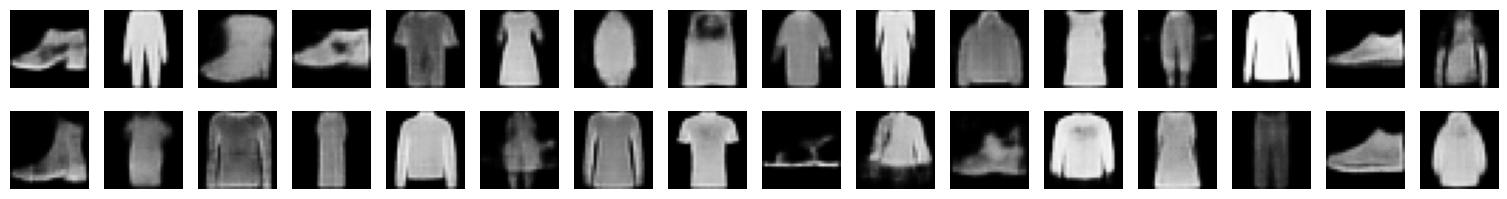

[226/300][468/469]	Loss: 21085.8457
[227/300][468/469]	Loss: 22311.5566
[228/300][468/469]	Loss: 22136.0195
[229/300][468/469]	Loss: 22479.2598
[230/300][468/469]	Loss: 22156.8594
[231/300][468/469]	Loss: 22487.2734
[232/300][468/469]	Loss: 21710.5215
[233/300][468/469]	Loss: 22795.9531
[234/300][468/469]	Loss: 23027.3535
[235/300][468/469]	Loss: 22304.3203
[236/300][468/469]	Loss: 22796.1641
[237/300][468/469]	Loss: 22670.8125
[238/300][468/469]	Loss: 23738.8906
[239/300][468/469]	Loss: 22226.8301
[240/300][468/469]	Loss: 22782.9609
[241/300][468/469]	Loss: 22073.3184
[242/300][468/469]	Loss: 21630.1660
[243/300][468/469]	Loss: 22103.9512
[244/300][468/469]	Loss: 21772.8711
[245/300][468/469]	Loss: 21920.3477
[246/300][468/469]	Loss: 21774.2773
[247/300][468/469]	Loss: 21304.7285
[248/300][468/469]	Loss: 22032.5723
[249/300][468/469]	Loss: 22514.9004
[250/300][468/469]	Loss: 23767.5312


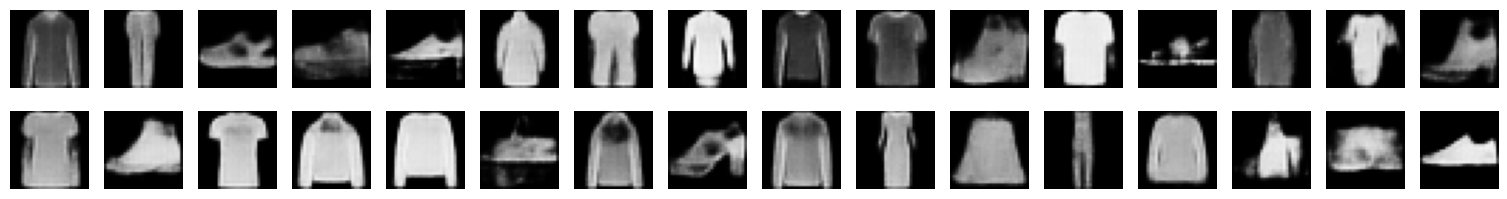

[251/300][468/469]	Loss: 22773.4883
[252/300][468/469]	Loss: 22526.9551
[253/300][468/469]	Loss: 22794.6211
[254/300][468/469]	Loss: 22189.4336
[255/300][468/469]	Loss: 20405.8359
[256/300][468/469]	Loss: 21484.9941
[257/300][468/469]	Loss: 21523.3008
[258/300][468/469]	Loss: 22176.1875
[259/300][468/469]	Loss: 23474.4922
[260/300][468/469]	Loss: 21680.2168
[261/300][468/469]	Loss: 22593.5430
[262/300][468/469]	Loss: 21252.2344
[263/300][468/469]	Loss: 21298.2988
[264/300][468/469]	Loss: 23498.3164
[265/300][468/469]	Loss: 21649.0234
[266/300][468/469]	Loss: 20706.1133
[267/300][468/469]	Loss: 24026.0332
[268/300][468/469]	Loss: 22280.0996
[269/300][468/469]	Loss: 22334.5859
[270/300][468/469]	Loss: 22478.2188
[271/300][468/469]	Loss: 22585.9062
[272/300][468/469]	Loss: 23454.9258
[273/300][468/469]	Loss: 21870.7012
[274/300][468/469]	Loss: 22636.7578
[275/300][468/469]	Loss: 22842.7246


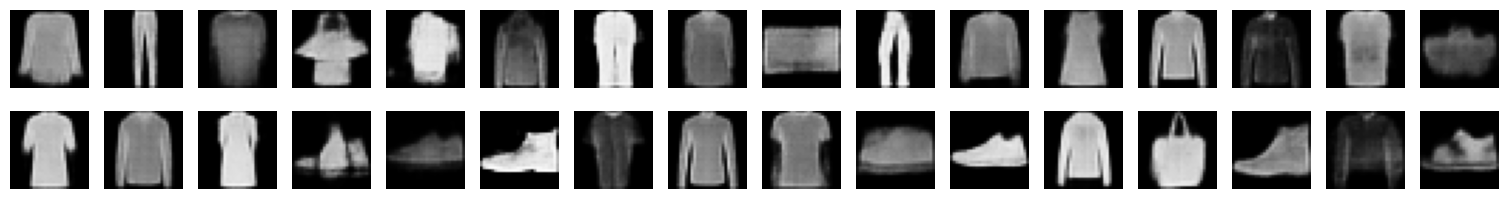

[276/300][468/469]	Loss: 22275.1914
[277/300][468/469]	Loss: 22554.7246
[278/300][468/469]	Loss: 22339.4258
[279/300][468/469]	Loss: 22852.6387
[280/300][468/469]	Loss: 22855.6758
[281/300][468/469]	Loss: 22614.1914
[282/300][468/469]	Loss: 22638.4121
[283/300][468/469]	Loss: 23026.5547
[284/300][468/469]	Loss: 21899.9551
[285/300][468/469]	Loss: 22794.3516
[286/300][468/469]	Loss: 22289.1152
[287/300][468/469]	Loss: 22225.5547
[288/300][468/469]	Loss: 22663.2266
[289/300][468/469]	Loss: 22848.5020
[290/300][468/469]	Loss: 20886.3184
[291/300][468/469]	Loss: 21896.9980
[292/300][468/469]	Loss: 22618.5273
[293/300][468/469]	Loss: 21409.2676
[294/300][468/469]	Loss: 21713.3164
[295/300][468/469]	Loss: 22668.8789
[296/300][468/469]	Loss: 22117.9434
[297/300][468/469]	Loss: 22834.7910
[298/300][468/469]	Loss: 21723.6602
[299/300][468/469]	Loss: 21377.2012
[300/300][468/469]	Loss: 21135.1895


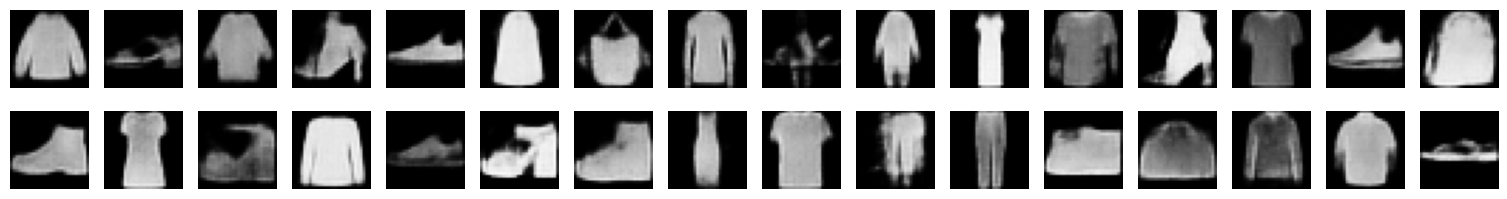

In [20]:
Utils.VAE_train(netE, netD, optimizer, criterion, dataloader, EPOCH_NUM, device)

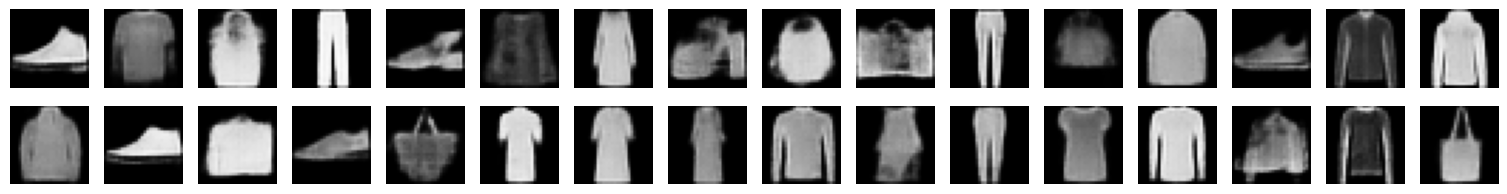

In [21]:
Utils.plot_images(netD.generate(64).detach().cpu().reshape(-1, 28, 28, 1), vmin=0, vmax=1, columns=16, height=1.2, 
                  width=1.2)

## Saving the model

In [23]:
model = nn.Sequential(netD, nn.Upsample(size=56, mode='nearest'))  # Upsampling the images to 56x56
dummy_input = torch.randn(1, LATENT_DIM).to(device)
Utils.save_model(model, dummy_input, 'VAE_Fashion_MNIST')